# Your First Deep Learning Model
### Building an Image Classifier with Fastai

Have you started, and stopped learning some part of data science and data analytics a bunch of times? Maybe you can build a classification model and you can kind of explain how random forests work, but your portfolio isn't much more than copies of the tutorial assignments? Are you curious about Deep Learning, neural networks, and all things artificial intelligence, but unsure of where to get started? Then you and I have a lot in common.

Today, we'll be exploring [Fast.ai](https://course.fast.ai/)'s course, Practical Deep Learning, *A free course designed for people with some coding experience, who want to learn how to apply deep learning and machine learning to practical problems.* This course flips the standard approach of learning data science on its head by starting with models, and then teaching you about how they work. We'll be recreating the image classifier from lesson 2, with a little twist. Rather than trying to figure out what kind of bear we're seeing, we will classifying vehicles: Is it a car? Is it a truck? Or is it blasphemy?

## The Drivetrain Approach

We will be using the Drivetrain Approach, which is a method for thinking about data projects described in the [book](https://course.fast.ai/Resources/book.html) in the following way:
>The Drivetrain Approach, illustrated below, was described in detail in ["Designing Great Data Products"](https://www.oreilly.com/radar/drivetrain-approach-data-products/). The basic idea is to start with considering your objective, then think about what actions you can take to meet that objective and what data you have (or can acquire) that can help, and then build a model that you can use to determine the best actions to take to get the best results in terms of your objective.

<img src="drivetrain-approach.png" id="drivetrain" caption="The Drivetrain Approach">

### Our Objective

We want to distinguish between cars, trush, and vehicles that have no business existing like Jeep Gladiators, El Caminos, and Subaru Bajas.

### Levers

We need to give our model examples of what a car looks like, what a truck looks like, and what should never have existed. Also, we need to get images at different angles, from different perspectives, etc.

### Data

We can use Microsoft Bing's API to download sample images of each! There might be better options, but I know how to use this one, so that's what we're going to do.

### Models

For the sake of this project, we'll be able to keep this pretty simple, but let's say we were contracted with a Department of Transportation. They're concerned about the added wear and tear of trucks on a bridge so they've setup a camera to determine what kind of vehicles are driving across this bridge so they can predict the life expectancy of this bridge. We would definitely need to consider different types of vehicles like vans, or SUVs. We also might want to identify what contributes to added stress on a bridge like weight and change our model to something that identifies vehicles that are likely to be heavier than a certain threshold.

## Getting Started

We'll be using Jupyter notebooks inside of [Paperspace Gradient](https://console.paperspace.com/signup?R=LQI4MAN) to build everything. Why? It's fast, it's inexpensive (there is even a free option), I don't want to waste a bunch of time trying to configure something else, and I know how to use it.

The first thing we need to do is make sure we have fastbook installed. In the cell below, the line starting with ! will communicate directly with the command line, and install or update the fastai library.

In [1]:
! [ -e /content ] && pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

Now let's import the libraries

In [2]:
from fastbook import *
from fastai.vision.widgets import *

## Gathering Data

To download images with Bing Image Search, sign up for a free [Microsoft Azure](https://azure.microsoft.com/en-us/services/cognitive-services/bing-web-search-api/) acount. There are some steps you'll need to take (Duckduckgo, Bing, or Google are your friends if you get confused). You'll need a key, which you can copy and enter in a cell like below (replace 'XXX' with your key):

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', 'XXXXXXXXXXXXXXXXXXXXXXXXXXXX')

Once you've set your key, you can use `search_images_bing`. Let's search for car and see what we get.

In [4]:
results = search_images_bing(key, 'car') #Run the bing api
ims = results.attrgot('contentUrl') #store the results as a list of urls
len(ims)


150

Looks like we have a list of 150 images. Fair warning, there's no way I can guarantee what is in those image search results. Let's look at an example

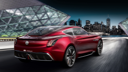

In [5]:
dest = 'images/car.jpg' #set the destination folder
download_url(ims[0], dest) #download the first image

im = Image.open(dest) #define the first image
im.to_thumb(128,128) #display a thumbnail of the first image

Looks like a car to me, let's use fastai's `download_images` to download all the URLs for each of our search terms. We'll put each in a separate folder. To make sure our car-truck category works, we'll be defining this category manually.

In [6]:
vehicle_types = 'car', 'truck' #define the other vehicle types
path = Path('vehicles')

if not path.exists(): #if there isn't a folder
    path.mkdir() #make a folder
    for o in vehicle_types: #for each vehicle
        dest = (path/o) #setting the destination to this specific folder
        dest.mkdir(exist_ok=True) #make the folder if it doesn't exist
        results = search_images_bing(key, f'{o}') #search for it
        download_images(dest, urls=results.attrgot('contentUrl')) #download the images

In [7]:
blasphemy = 'Jeep Gladiator', 'el camino', 'subaru baja' #define the vehicles we're considering
path = Path('vehicles/blasphemy')  #set a path for these images to be stored

if not path.exists(): #if there isn't a folder
    path.mkdir() #make a folder
    for o in blasphemy: #for each vehicle
        dest = (path) #setting the destination to this specific folder
        dest.mkdir(exist_ok=True) #make the folder if it doesn't exist
        results =search_images_bing(key, f'{o}') #search for it
        download_images(dest, urls=results.attrgot('contentUrl')) #download the images
        
path = path.parent #reset the path

Let's check our folders to see if they have images.

In [8]:
fns = get_image_files(path)
fns

(#718) [Path('vehicles/truck/d68e5e7d-1d2c-4530-8a9c-452a17f6a93d.jpg'),Path('vehicles/truck/58d29a32-5253-4962-ad1a-f6ef3e71c701.jpg'),Path('vehicles/truck/b003e2be-acf9-4fbb-a4f1-7623ccdbfeed.jpg'),Path('vehicles/truck/255d8e50-a915-45a4-b4a4-5fe32f0a0e05.jpg'),Path('vehicles/truck/8a6d22f4-6a00-4157-b47f-1d1de8b53efd.jpg'),Path('vehicles/truck/a99fdec2-5d90-4f7d-86e0-653d76a46614.jpg'),Path('vehicles/truck/d12c3c1d-226d-4a5f-9ef4-104de657ccd9.jpeg'),Path('vehicles/truck/3e0b58be-c33f-450a-86fa-bbc576ff1df1.jpg'),Path('vehicles/truck/19ac7053-e160-44b7-a351-debf24ca2c45.jpg'),Path('vehicles/truck/4962ad1b-5959-4969-96cf-5aeba8e529a4.jpg')...]

### Getting the Data Ready for Our Model

Assuming you've done some data projects before now, you're probably ready for this to be a biiiig, heavy section, with a bunch of practical tips for cleaning your data. We only have a little bit of that to do.

#### First 
We probably have some corrupted files, let's get rid of those.

In [9]:
failed = verify_images(fns)
failed

(#15) [Path('vehicles/truck/7823b224-d1e7-4fd8-bc61-30b0af6180e6.jpg'),Path('vehicles/truck/b44d9565-93ad-4a9a-82e5-8ec083cae539.jpg'),Path('vehicles/car/25b3be1e-9566-43e3-b7fb-410fca2de41f.jpg'),Path('vehicles/car/53b034f3-e204-4a92-a1cd-90299b89cd0a.jpg'),Path('vehicles/car/a331ab55-ca59-471e-a72f-ff3897a8e9e9.jpg'),Path('vehicles/blasphemy/3bd7a2a5-b7eb-4290-9790-f3bca55077fb.jpg'),Path('vehicles/blasphemy/66b571d3-a169-4098-916c-905ccbcf467e.jpg'),Path('vehicles/blasphemy/bc7e9438-9fff-4348-88ec-e42f196da94c.jpg'),Path('vehicles/blasphemy/e8fc0196-5e15-4af3-90cc-8b5bec8bf118.jpg'),Path('vehicles/blasphemy/c6e67822-176f-44ab-9b0b-4bea2a96779e.jpg')...]

To remove all of the failed images, we'll `unlink` each of them. To do this, we'll use the `map` method, which calls the passed function on each element of the collections.

In [10]:
failed.map(Path.unlink);

#### Second

We need our data to be setup so that our model can understand it. We'll do that using `DataLoaders`. `DataLoaders` needs to know the following things:

* What kind of data we're working with
* How to get the list of items
* How to label these items
* How to create the validation set

First, we'll setup a `DataBlock` which is essentially a template for creating a `DataLoaders`.

In [11]:
vehicles = DataBlock(
    blocks = (ImageBlock, CategoryBlock), #we're setting our independent and dependent variables
    get_items = get_image_files, #get_image_files tells fastai to get a list of all of the image files in a path
    splitter = RandomSplitter(valid_pct = 0.2, seed = 42), #We're telling fastai to do a train-test split
    get_y = parent_label, #this gets the name of the folder the file is in, and uses that to label the data
    item_tfms = Resize(128)) #this makes the images a standard size to make things easier


Let's tell our dataloader the source of our data (the path to the images) and take a look at a small sample size

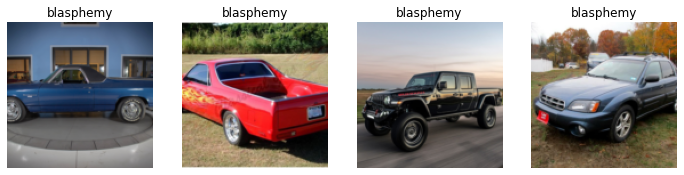

In [12]:
dls = vehicles.dataloaders(path)
dls.valid.show_batch(max_n=4, nrows=1)

#### Image Cleaning

Because we want all of our images to be the same size, there are several approaches we can take. We can `Resize` which will remove information from the image, we can `Squish` which will distort the image, and we can `Pad` which will shrink the image and add black bars to keep the aspect ratio (like a wide screen moving on a television that isn't widescreen). For more details about the strengths and weaknesses of each approach, I recommend you look at Chapter 2 of the [fast.ai book](https://course.fast.ai/Resources/book.html). 

We'll be using `RandomResizedCrop` which randomly selects a part of each image, and crops to just that part. This approach lets our model focus on different features in different images. With this, we need to make sure we set the value `min_scale` as this tells fastai how much of the image to select at a minimum each time.

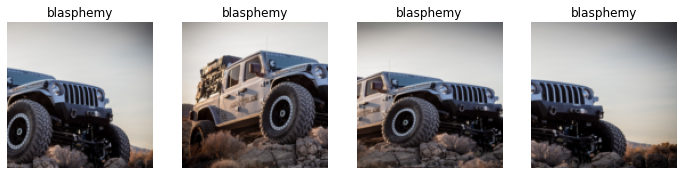

In [13]:
vehicles = vehicles.new(item_tfms = RandomResizedCrop(128, min_scale=0.3)) #define our new datablock with different parameters for item_tfms
dls = vehicles.dataloaders(path) #tell our dataloader the source of our data
dls.train.show_batch(max_n=4, nrows=1, unique=True) #show a sample, set unique=true so we see different versions of 1 image

### Data Augmentation

Pictures of things are often captured in ideal light, and at ideal angles, which can create blindspots in our data. To help address this, we will be creating random variations of our input data such that they appear different but don't change the meaning of the data. This is called data augmentation. Some common examples are rotating, flipping, perspective warping, brightness changes, and contrast changes. 

The example below shows how this can affect our data:

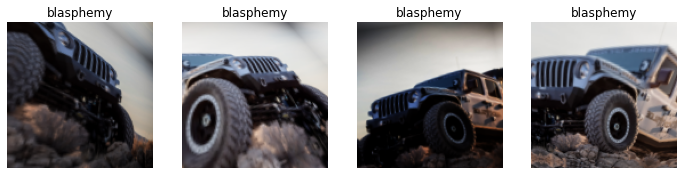

In [14]:
#because our images are all already 1 size, we can use batch_tfms for our data augmentation which saves a lot of time
vehicles = vehicles.new(item_tfms = RandomResizedCrop(128, min_scale=0.3), batch_tfms = aug_transforms(mult=2)) #define our new datablock
dls = vehicles.dataloaders(path) #tell our dataloader the source of our data
dls.train.show_batch(max_n=4, nrows=1, unique=True) #show a sample, set unique=true so we see different versions of 1 image

### Using a Trained Model to Clean our Data

Let's build our model and see how it does!

#### First we define our datablock

In [15]:
vehicles = vehicles.new(item_tfms = RandomResizedCrop(224, min_scale=0.5), 
                        batch_tfms = aug_transforms()) #define our new datablock
dls = vehicles.dataloaders(path) #tell our dataloader the source of our data

#### Second we create our `Learner`

`vision_learner` tells fastai to create a convolutional neural network (CNN) and specifies what kind of model (architecture) to use, what data we want to use, and what metrics to use). One thing that I think is important to note is that `vision_learner` will use a `pretrained` model by default. This means that it will use a model that already exists, remove the last layer and replace it with one or more new layers. This is called **transfer learning** and it saves you a lot of time! 

`fine_tune` tells fastai how to fit the model. By using `fine_tune` we start with the pretrained model. We could also use `fit`, but we would be discarding all of the capabilities of the pretrained model.

If you want to know more, start with Chapter 1 of the [fast.ai book](https://course.fast.ai/Resources/book.html).

In [16]:
learn = vision_learner(dls, resnet18, metrics = error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.475826,0.834680,0.257143,00:13


epoch,train_loss,valid_loss,error_rate,time
0,0.697600,0.625915,0.207143,00:12
1,0.547055,0.633827,0.200000,00:11
2,0.444711,0.430104,0.107143,00:13
3,0.394204,0.359331,0.100000,00:11


Now let's visualize the mistakes the model made using a confusion matrix.

In a ***confusion matrix*** items in the diagnoal are labeled correctly, and items anywhere else are mislabeled. 

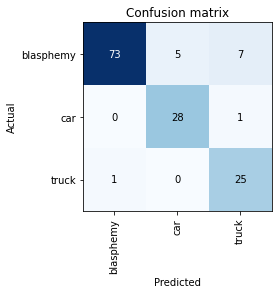

In [17]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

We did okay. We predicted quite a few vehicles as trucks that turned out to be cars, and quite a few cars that turned out to be trucks. One thing you'll notice here is that our data is heavily skewed. That's because our initial dataset has 450 examples of blasphemous vehicles and only 150 examples of cars and 150 examples of trucks.

As we learn more, we'll probably find some tricks to help with this, but for now, we'll just be happy with what we have. Let's take a look at exactly where our errors are occuring.

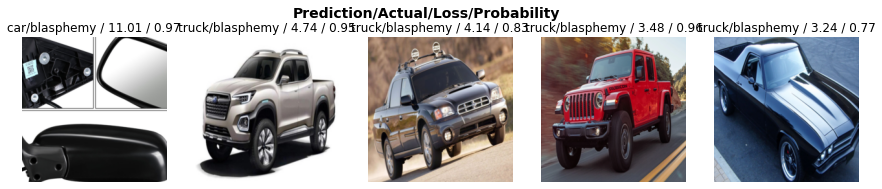

In [18]:
interp.plot_top_losses(5, nrows=1)

As we can see, we have some data cleaning to do. Fastai gives us a handy GUI interface to make this super easy.

We can review the images and determine the appropriate course of action. The GUI doesn't do anything until the code cells afterward are run

In [19]:
cleaner = ImageClassifierCleaner(learn)
cleaner

In [20]:
for idx in cleaner.delete(): cleaner.fns[idx].unlink() #deletes (unlinks) images selected for deletion
for idx, cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) #moved the images to different categories

### Next Steps

Now that we have a clean, working model that we're happy with, it's time to save it!

In [21]:
learn.export()

Now that we have our model saved, the next step will be to turn it into an online application. Stay tuned for my next post which will walk you through the necessary steps to build your model into something you can send to your friends!